# Initial problem resolution

In [105]:
using CSV
using DataFrames
using Plots
using JuMP
using Gurobi
using Pkg
using TikzGraphs
using Graphs
import GraphPlot
import Colors

Let's start by creating everything we need.

In [106]:
bus_system = CSV.read("IEEE_33_bus_system.csv", DataFrame)
bus_system[1:5, :]

buses = 1:33    

1:33

## Sets

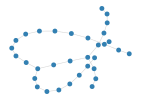

In [107]:
Lines = []
for i in 1:size(bus_system, 1)
    if bus_system[i, :"From bus"] != bus_system[i, :"To bus"]
        push!(Lines, (bus_system[i, :"From bus"], bus_system[i, :"To bus"]))
    end
end

g = SimpleGraph(33) 
for (u, v) in Lines
    add_edge!(g, u, v)
end
GraphPlot.gplot(g, nodefillc=map(x -> RGB(0.2,0.5,0.7), 1:nv(g)))

In [108]:
Lines_m = Dict(i => [] for i in 1:33) # bus i is connected to lines Lines_m[i]
index = 1
for i in Lines
    push!(Lines_m[i[1]], index)
    push!(Lines_m[i[2]], index)
    index += 1
end


In [109]:
# points of interconnection?

## Parameters

In [110]:
mask = (bus_system[!, :"From bus"] .== 1) .& (bus_system[!, :"To bus"] .== 2)
filtered_bus_system = bus_system[mask, :]
filtered_bus_system

Row,Branch No.,From bus,To bus,R (Ω),X (Ω),P (kW),Q (kW)
,Int64,Int64,Int64,Float64,Float64,Int64,Int64
1,1,1,2,0.0922,0.0477,0,0


Let's fetch the resistance and reactance of each line from our table.

In [111]:
r_mn = Dict(i => 0. for i in Lines)
x_mn = Dict(i => 0. for i in Lines)

for i in Lines
    mask = (bus_system[!, :"From bus"] .== i[1]) .& (bus_system[!, :"To bus"] .== i[2])
    r_mn[i] = bus_system[mask, :][1, :"R (Ω)"]
    x_mn[i] = bus_system[mask, :][1, :"X (Ω)"]
end

In [112]:
p_m = Dict()
q_m = Dict()

for i in buses
    mask = bus_system[!, :"To bus"] .== i
    if ! isempty(bus_system[mask, :])
        p_m[i] = bus_system[mask, :][1, :"P (kW)"]
        q_m[i] = bus_system[mask, :][1, :"Q (kW)"]
    else
        p_m[i] = 0
        q_m[i] = 0
    end

end



We need to compute the admittance (conductance and susceptance) $g_{mn}$ and $b_{mn}$ from the impedance $r + i*x$

In [113]:
g_mn = Dict()
b_mn = Dict()

for i in Lines
    g_mn[i] = 1 / (r_mn[i]^2 + x_mn[i]^2) * (r_mn[i] ^2)
    b_mn[i] = - 1 / (r_mn[i]^2 + x_mn[i]^2) * (x_mn[i] ^2)
end

In [114]:
# Add in the set of interconnection points to bus m

C_m = Dict(i => [] for i in 1:33)

for i in Lines # for now we will suppose you can connect at every point
    C_m[i[1]] = [i[1]]
end
C_m

Dict{Int64, Vector{Any}} with 33 entries:
  5  => [5]
  16 => [16]
  20 => [20]
  12 => [12]
  24 => [24]
  28 => [28]
  8  => [8]
  17 => [17]
  30 => [30]
  1  => [1]
  19 => [19]
  22 => []
  23 => [23]
  6  => [6]
  32 => [32]
  11 => [11]
  9  => [9]
  31 => [31]
  14 => [14]
  ⋮  => ⋮

## Variables

In [115]:
model = Model(Gurobi.Optimizer)

set_optimizer_attributes(model, "TimeLimit" => 60)

# Lines
@variable(model, pl_mn[1:length(Lines)])
@variable(model, ql_mn[1:length(Lines)])


# Buses
@variable(model, pD_m[buses]) # pD_m
@variable(model, pG_m[buses]) # pG_m
@variable(model, pM_c[buses]) # pM_c

@variable(model, qD_m[buses]) # qD_m
@variable(model, qG_m[buses]) # qG_m
@variable(model, qM_c[buses]) # q_Mc

@variable(model, V_m[buses])  # V_m voltage magnitude at m
@variable(model, θ_m[buses])  # θ_m voltage angle at m
@variable(model, ΔV_m[buses]) # ΔV_m voltage magnitude deviation at m
@variable(model, Δθ_m[buses]);# Δθ_m voltage angle deviation at m

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter TimeLimit to value 60


## Equations

### Linear power flow equations

We base the equations on (11), (12):

$\forall m,n \space PL_{mn} = g_{mn} (\Delta V_m - \Delta V_n) + g_{mn} \Delta V_m  (\Delta V_m - \Delta V_n) - b_{mn} (\Delta \theta_m - \Delta \theta_n)$


$\forall m,n \space QL_{mn} = -b_{mn} (\Delta V_m - \Delta V_n) - b_{mn} \Delta V_m  (\Delta V_m - \Delta V_n) - g_{mn} (\Delta \theta_m - \Delta \theta_n)$

There is a non-linearity in there. For now, we will remove the non-linear term before reintroducing $\Delta \hat{V}_m$ as the solution of the lossless model.

In [116]:
for i in 1:length(Lines)
    m = Lines[i][1]
    n = Lines[i][2]
    @constraint(model, 
        pl_mn[i] ==   g_mn[Lines[i]] * (ΔV_m[m] - ΔV_m[n]) # + g_mn[Lines[i]] * ΔV_m[i[1]] * (ΔV_m[m] - ΔV_m[n]) 
                    - b_mn[Lines[i]] * (Δθ_m[m] - Δθ_m[n])
    )
    @constraint(model, 
        ql_mn[i] == - b_mn[Lines[i]] * (ΔV_m[m] - ΔV_m[n])  # - b_mn[Lines[i]] * ΔV_m[m] * (ΔV_m[m] - ΔV_m[n]) 
                    - g_mn[Lines[i]] * (Δθ_m[m] - Δθ_m[n])
    )
end


@constraint(model, -5 .<= pl_mn .<= 5) 
@constraint(model, -5 .<= ql_mn .<= 5)

32-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape}}:
 ql_mn[1] in [-5, 5]
 ql_mn[2] in [-5, 5]
 ql_mn[3] in [-5, 5]
 ql_mn[4] in [-5, 5]
 ql_mn[5] in [-5, 5]
 ql_mn[6] in [-5, 5]
 ql_mn[7] in [-5, 5]
 ql_mn[8] in [-5, 5]
 ql_mn[9] in [-5, 5]
 ql_mn[10] in [-5, 5]
 ⋮
 ql_mn[24] in [-5, 5]
 ql_mn[25] in [-5, 5]
 ql_mn[26] in [-5, 5]
 ql_mn[27] in [-5, 5]
 ql_mn[28] in [-5, 5]
 ql_mn[29] in [-5, 5]
 ql_mn[30] in [-5, 5]
 ql_mn[31] in [-5, 5]
 ql_mn[32] in [-5, 5]

### Power balance equations

In [117]:
for m in buses
    @constraint(model, 
          pG_m[m] 
        + sum(pl_mn[line] for line in Lines_m[m]) 
        + sum(pM_c[c] for c in C_m[m]) 
        == pD_m[m])
    @constraint(model, 
           qG_m[m] 
        + sum(ql_mn[line] for line in Lines_m[m]) 
        + sum(qM_c[c] for c in C_m[m]) 
        == qD_m[m])
end

In [118]:
@constraint(model, 1 .>= pM_c[2:end] .>= -1)
@constraint(model, 1 .>= qM_c .>= -1)

1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, 1:33
And data, a 33-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape}}:
 qM_c[1] in [-1, 1]
 qM_c[2] in [-1, 1]
 qM_c[3] in [-1, 1]
 qM_c[4] in [-1, 1]
 qM_c[5] in [-1, 1]
 qM_c[6] in [-1, 1]
 qM_c[7] in [-1, 1]
 qM_c[8] in [-1, 1]
 qM_c[9] in [-1, 1]
 qM_c[10] in [-1, 1]
 ⋮
 qM_c[25] in [-1, 1]
 qM_c[26] in [-1, 1]
 qM_c[27] in [-1, 1]
 qM_c[28] in [-1, 1]
 qM_c[29] in [-1, 1]
 qM_c[30] in [-1, 1]
 qM_c[31] in [-1, 1]
 qM_c[32] in [-1, 1]
 qM_c[33] in [-1, 1]

In [119]:
@constraint(model, pM_c[1] == 40)

pM_c[1] == 40

In [120]:
@constraint(model, -0.5 .<= ΔV_m .<= 0.05)
@constraint(model, -0.5 .<= Δθ_m .<= 0.5)


1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, 1:33
And data, a 33-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape}}:
 Δθ_m[1] in [-0.5, 0.5]
 Δθ_m[2] in [-0.5, 0.5]
 Δθ_m[3] in [-0.5, 0.5]
 Δθ_m[4] in [-0.5, 0.5]
 Δθ_m[5] in [-0.5, 0.5]
 Δθ_m[6] in [-0.5, 0.5]
 Δθ_m[7] in [-0.5, 0.5]
 Δθ_m[8] in [-0.5, 0.5]
 Δθ_m[9] in [-0.5, 0.5]
 Δθ_m[10] in [-0.5, 0.5]
 ⋮
 Δθ_m[25] in [-0.5, 0.5]
 Δθ_m[26] in [-0.5, 0.5]
 Δθ_m[27] in [-0.5, 0.5]
 Δθ_m[28] in [-0.5, 0.5]
 Δθ_m[29] in [-0.5, 0.5]
 Δθ_m[30] in [-0.5, 0.5]
 Δθ_m[31] in [-0.5, 0.5]
 Δθ_m[32] in [-0.5, 0.5]
 Δθ_m[33] in [-0.5, 0.5]

In [121]:
for i in 1:33
    @constraint(model, pD_m[i] == p_m[i])
    @constraint(model, qD_m[i] == q_m[i])
end

### Objective

In [122]:
@objective(
    model,
    Max,
    sum(pG_m)    
)

pG_m[1] + pG_m[2] + pG_m[3] + pG_m[4] + pG_m[5] + pG_m[6] + pG_m[7] + pG_m[8] + pG_m[9] + pG_m[10] + pG_m[11] + pG_m[12] + pG_m[13] + pG_m[14] + pG_m[15] + pG_m[16] + pG_m[17] + pG_m[18] + pG_m[19] + pG_m[20] + pG_m[21] + pG_m[22] + pG_m[23] + pG_m[24] + pG_m[25] + pG_m[26] + pG_m[27] + pG_m[28] + pG_m[29] + pG_m[30] + pG_m[31] + pG_m[32] + pG_m[33]

In [123]:
JuMP.optimize!(model)

Set parameter TimeLimit to value 60
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 392 rows, 589 columns and 1095 nonzeros
Model fingerprint: 0xc2e42f1c
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-02, 5e+00]
  RHS range        [1e+01, 6e+02]
Presolve removed 392 rows and 589 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6847894e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.684789354e+03

User-callback calls 48, time in user-callback 0.00 sec


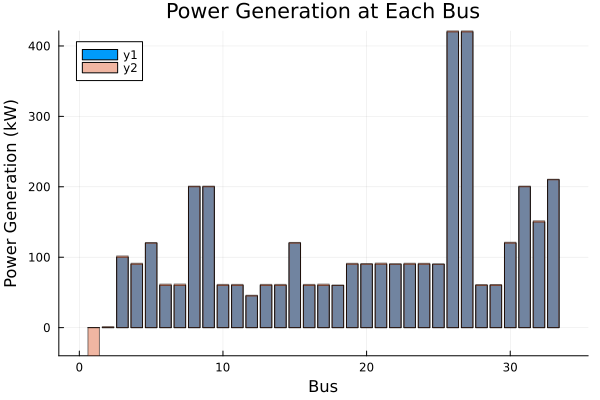

In [124]:
bar(p_m, title="Power Generation at Each Bus", xlabel="Bus", ylabel="Power Generation (kW)")
bar!(value.(pG_m).data, title="Power Generation at Each Bus", xlabel="Bus", ylabel="Power Generation (kW)", alpha=0.5)


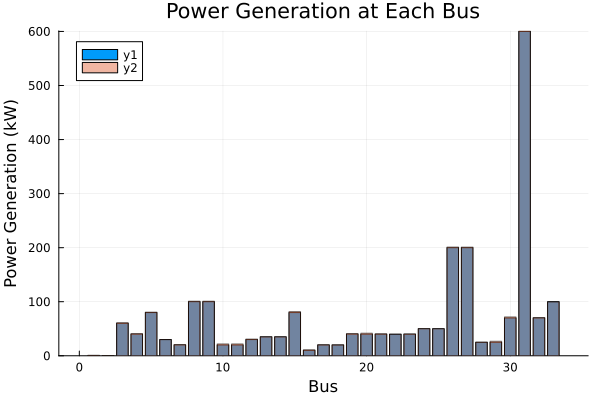

In [125]:
bar(q_m, title="Power Generation at Each Bus", xlabel="Bus", ylabel="Power Generation (kW)")
bar!(value.(qG_m).data, title="Power Generation at Each Bus", xlabel="Bus", ylabel="Power Generation (kW)", alpha=0.5)


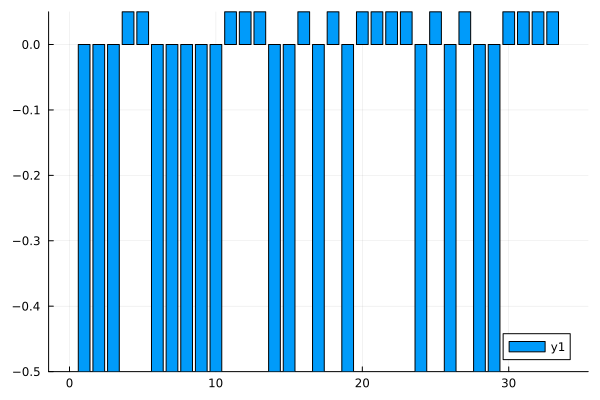

In [126]:
bar(value.(V_m+ΔV_m).data)
